# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Preamble – Imports

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO)
logger = logging.getLogger("trafficsigns")

In [2]:
import pickle
import os
import sys
import time
import datetime
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import sklearn.utils
import cv2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
print("# Versions")
for module in (np, pd, matplotlib, tf, sklearn, cv2):
    print("{:s}=={:8s}".format(module.__package__, module.__version__))

# Versions
numpy==1.12.0  
pandas==0.19.2  
matplotlib==2.0.0   
tensorflow==1.0.0   
sklearn==0.18.1  
cv2==3.2.0   


In [4]:
tf_version_required = '1.0.0'
assert tf.__version__ == tf_version_required, "This code requirements tensorflow=={}".format(tf_version_required)

### Preamble - Helpers 

In [5]:
def grayscale(x, keepdims=True):
    """Convert an array of RGB images to grayscale."""
    if x.shape[-1] == 1:
        # Assume is already grayscale
        return x
    y = .299 * x[..., 0] + .587 * x[..., 1] + .114 * x[..., 2]
    if x.dtype == np.uint8:
        # saturate cast to bytes
        y = np.clip(y, 0, 255).astype(np.uint8)
    if keepdims and x.ndim == 4:
        y = y[..., np.newaxis]
    return y

In [6]:
def showgrid(images, predictions=None, rows=None, cols=None, **kwargs):
    """Display a grid of images.
    
    Args:
      images: a 4D array
      predictions: an optional list of labels or list of pairs (label, prediction == ground_truth)
      rows: force the number of rows in the grid
      cols: force the number of columns
      kwargs: keyword arguments pass to `matplotlib.subplots`.
    """
    import matplotlib.patches as patches
    
    n = len(images)
    if rows:
        cols = math.ceil(n / rows)
    else:
        if not cols:
            cols = min(12, math.ceil(math.sqrt(n)))
        rows = math.ceil(n / cols)

    if images.dtype != np.uint8:
        images = grayscale(images)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows), sharey=True, sharex=True)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    if not hasattr(axes, 'flat'):
        axes = np.asarray([axes])
    for ax in axes.flat: ax.axis('off')
    
    if predictions is None:
        for ax, im in zip(axes.flat, images):
            ax.imshow(np.squeeze(im), **kwargs)
            ax.axis('on')
            ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')    
    else:
        for ax, im, prediction_ in zip(axes.flat, images, predictions):
            ax.imshow(np.squeeze(im), *kwargs)
            ax.axis('on')
            ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')    
            
            if type(prediction_) == tuple:
                prediction, ok = prediction_
            else:
                prediction, ok = prediction_, None
            
            color = 'y' if ok is None else 'g' if ok else 'r'
            r = patches.Rectangle((0.2, 0.2), 8, 8, color=color, alpha=.8)
            ax.add_patch(r)
            rx, ry = r.get_xy()
            cx = rx + r.get_width()/2.0
            cy = ry + r.get_height()/2.0
            ax.annotate(str(prediction), (cx, cy), color='w', weight='bold', 
                        fontsize=12, ha='center', va='center')


---
## Step 0: Load The Data

In [7]:
training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [8]:
del train, valid, test

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [9]:
# TODO: Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [10]:
SIGNNAMES = pd.read_csv("signnames.csv", index_col=0).sort_index().SignName

In [11]:
def display_class_frequencies(labels_and_legend, normalized=True):
    """Display class frequencies."""
    dataset = {}
    for y, name in labels_and_legend:
        if normalized:
            n = len(y)
        else:
            n = 1
        dataset[name] = [(y == label).sum() / n for label in range(n_classes)]    
    dataset = pd.DataFrame(dataset)
    
    fig, ax = plt.subplots(1, 1, figsize=(20,5), )
    ax.set_title('class frequency')
    dataset.plot.bar(ax=ax)
    ax.grid(axis='y', alpha=.5)
    if not normalized:
        ylim = ax.get_ylim()[1]
        if ylim > 4000:
            step = 400
        else:
            step = 200
        ax.set_yticks(np.arange(0, ylim, step))

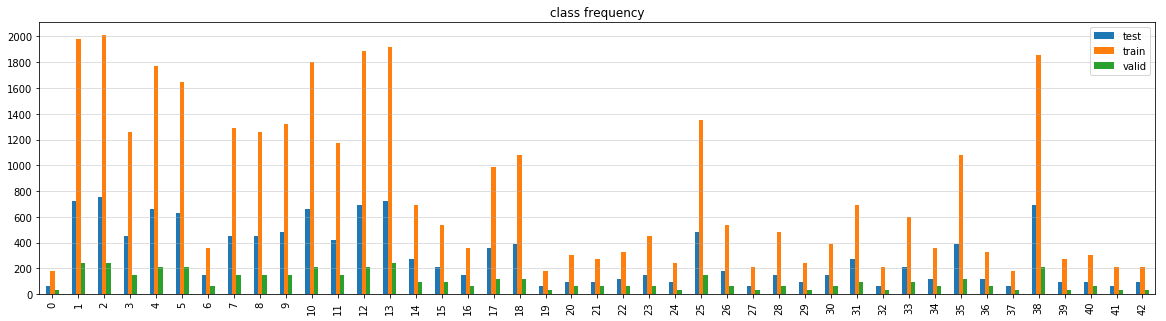

In [13]:
display_class_frequencies([(y_train, 'train'), (y_valid, 'valid'), (y_test, 'test')], normalized=False)

The dataset is very unbalanced but this can represent the real frequency of the data.

In [14]:
def display_random_sample(images, labels, samples_per_class, classes=None, dpi=96, **kwargs):
    """Display a random sample of images."""
    if classes is None:
        classes = sorted(np.unique(labels))
    n_classes = len(classes)
    
    # Handel grayscale images
    images = np.squeeze(images)
        
    if images.dtype != np.uint8:
        images = grayscale(images, keepdims=False)
    
    fig, axes = plt.subplots(n_classes, 1, figsize=(samples_per_class*1.5, n_classes*2), dpi=dpi, **kwargs)
    for k, label in enumerate(classes):
        labels_mask = labels == label
        n_label_samples = labels_mask.sum()
        # pick a random sample matching current label
        samples = images[np.random.choice(np.where(labels_mask)[0], samples_per_class, replace=False)]
        sample_image = np.hstack(samples)

        ax = axes[k]
        ax.imshow(sample_image, cmap='gray')
        ax.axis('off')
        ax.text(0, -5, "{:2d}. {:s} ({:d} samples)".format(label, SIGNNAMES[label], n_label_samples), ha='left', va='top', fontsize=10)

Display a random sample of 10 images per class in the train dataset.

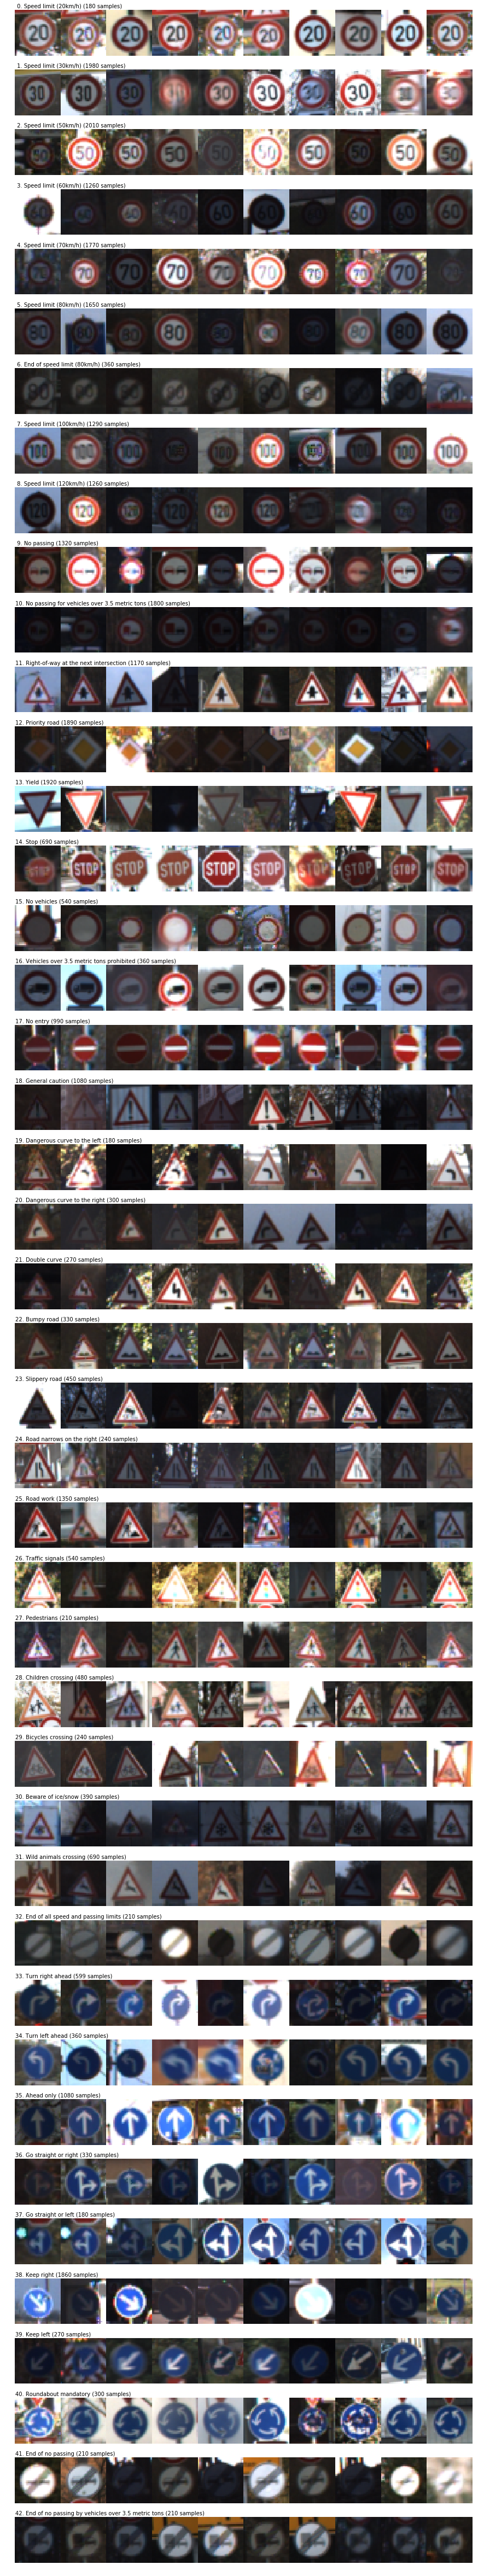

In [15]:
display_random_sample(X_train, y_train, 10, dpi=72)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

There are notable variations in the illumination conditions of the images.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Preprocessing

In [16]:
def equalize(im, clahe=None):
    lab = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    if clahe is None:
        lab[...,0] = cv2.equalizeHist(lab[...,0])
    else:
        lab[...,0] = clahe.apply(lab[...,0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [17]:
def preprocess(source):
    """Preprocess RGB images.

    Parameters
    ----------
    source  : RGB image or array of RGB images

    """
    if source.ndim == 3:
        # Support just one RGB image adding an extra dimension
        source = source[np.newaxis, ...]
        
    # Convert to grayscale
    #x = grayscale(source)
    x = source.copy()
    
    # Local histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    for im in x:
        #im[...,0] = clahe.apply(im[...,0])
        im[:] = equalize(im, clahe)
    
    # scale to [-1, 1] and convert to float32
    return np.float32(x / 128.0 - 1.)

In [18]:
training_dataset = preprocess(X_train), y_train
validation_dataset = preprocess(X_valid), y_valid
testing_dataset = preprocess(X_test), y_test

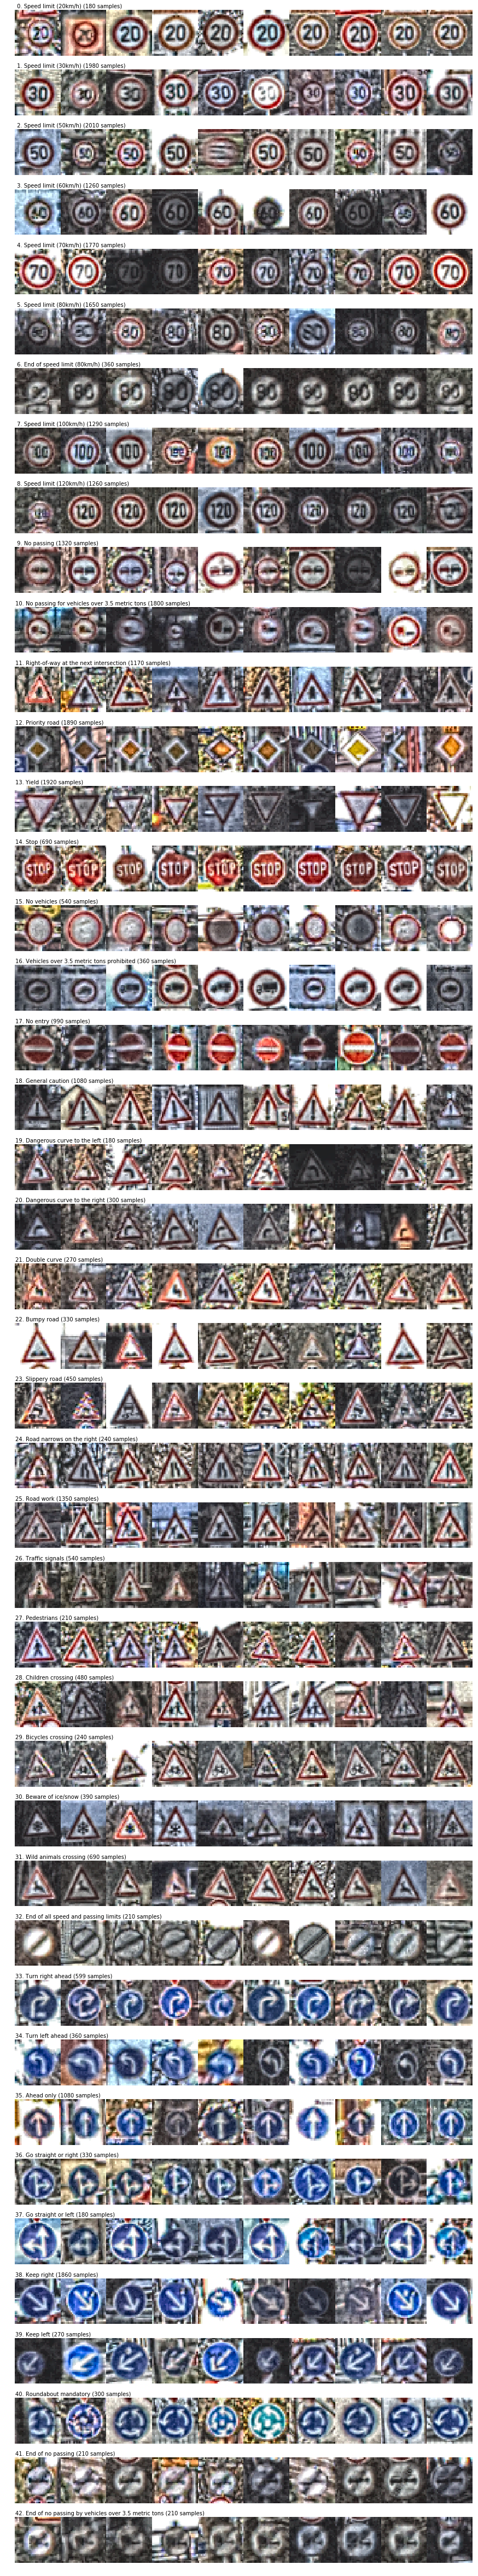

In [19]:
display_random_sample(np.clip((training_dataset[0]+1)*128, 0, 255).astype(np.uint8), y_train, 10, dpi=72)

#### Data Augmentation

In [20]:
class RandomWarp:
    """Apply a random affine + perspective transformation to an image."""

    def __init__(self, shift_range, scale_range, rotation_range, projection_scale):
        self.shift_range = shift_range
        self.scale_range = scale_range
        self.rotation_range = rotation_range
        self.projection_scale = projection_scale
    
    def pick_random_in_range(self, in_range):
        return random.uniform(in_range[0], in_range[1])
    
    def __call__(self, src_array):
        dst_array = np.zeros_like(src_array)
        n, rows, cols = src_array.shape[:3]
        for i, src in enumerate(src_array):
            # Rotation
            angle = self.pick_random_in_range(self.rotation_range)
            scale = self.pick_random_in_range(self.scale_range)
            cx = cols/2 + self.pick_random_in_range(self.shift_range)
            cy = rows/2 + self.pick_random_in_range(self.shift_range)
            M = cv2.getRotationMatrix2D((cx, cy), angle, scale)

            # Translation
            tx = self.pick_random_in_range(self.shift_range)
            ty = self.pick_random_in_range(self.shift_range)
            M[:, 2] += (tx, ty)

            dst = cv2.warpAffine(src, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

            if self.projection_scale:
                pts1 = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])
                pts2 = np.float32(pts1 + np.random.normal(0, self.projection_scale, (4, 2)))
                M = cv2.getPerspectiveTransform(pts2, pts1)
                dst = cv2.warpPerspective(dst, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

            if dst.ndim < src.ndim:
                dst = dst[..., np.newaxis]
            dst_array[i] = dst
        return dst_array

In [21]:
def augment_dataset(dataset, perturbation, fix_class_size):
    """Augment and balance a dataset with random perturbations."""
    features, labels = dataset
    
    # Include the original
    augmented_x = [features]
    augmented_y = [labels]

    for label in sorted(np.unique(labels)):
        label_mask = labels == label
        label_count = label_mask.sum()

        num_new_samples = max(fix_class_size - label_count, int(label_count * .1))
        
        x = features[label_mask][np.random.choice(np.arange(label_count), num_new_samples)]
        x = perturbation(x)

        y = np.ones(num_new_samples, dtype=labels.dtype) * label
        
        augmented_x.append(x)
        augmented_y.append(y)

    augmented_x = np.row_stack(augmented_x)
    augmented_y = np.concatenate(augmented_y)
    return augmented_x, augmented_y

In [22]:
perturbation = RandomWarp(shift_range=(-2,2),
                          scale_range=(.8,1.2),
                          rotation_range=(-20,20),
                          projection_scale=2.5)

augmented_dataset = augment_dataset(training_dataset, perturbation, fix_class_size=3000)

In [23]:
print("Number of training samples:", len(augmented_dataset[0]))

Number of training samples: 129000


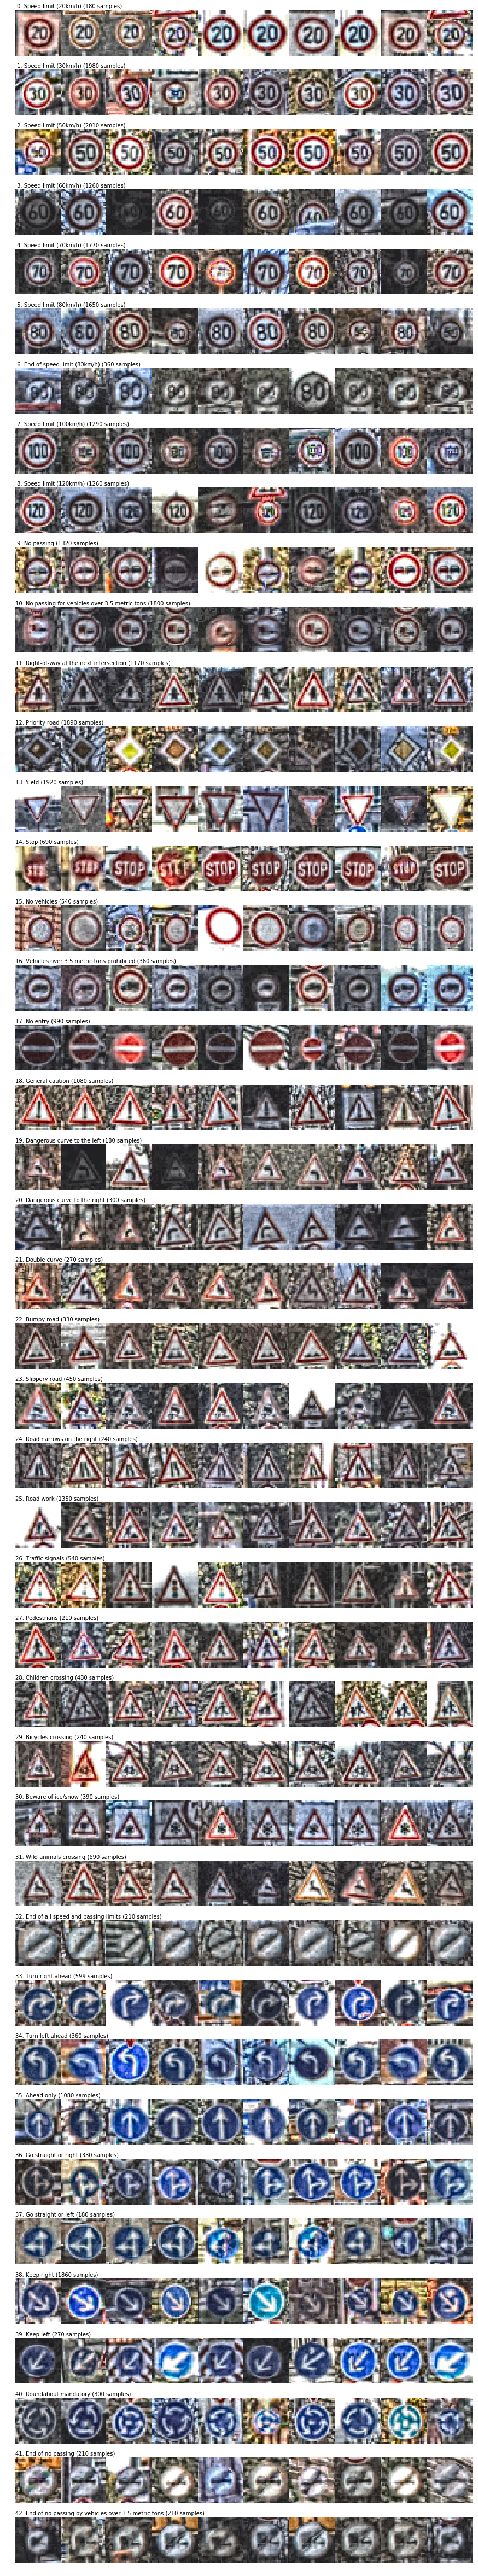

In [24]:
display_random_sample(np.clip((augmented_dataset[0]+1)*128, 0, 255).astype(np.uint8), y_train, 10, dpi=72)

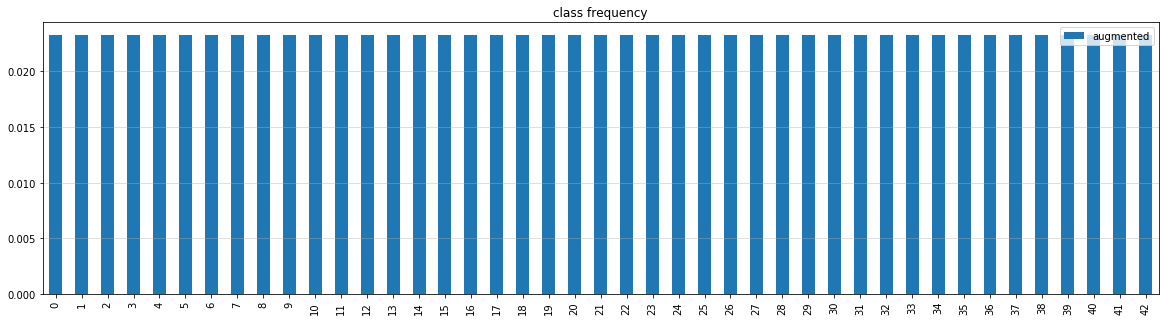

In [25]:
display_class_frequencies([(augmented_dataset[1], 'augmented')], normalized=True)

Save the preprocessed data on disk.

In [26]:
os.makedirs("data/preprocessed", exist_ok=True)
datasets = (('train', augmented_dataset), 
            ('valid', validation_dataset), 
            ('test', testing_dataset))
for name, dataset in datasets:
    with open("data/preprocessed/{}.p".format(name), "wb") as f:
        pickle.dump(dataset, f)

### Model Architecture

In [27]:
def build_graph(model_architecture, params):    
    is_training = tf.placeholder_with_default(tf.constant(False), None, name='is_training')
    
    x = tf.placeholder(tf.float32, (None,)+params['image_shape'], name='x')
    y = tf.placeholder(tf.int32, (None,), name='y')
    one_hot_y = tf.one_hot(y, params['n_classes'])
    
    endpoints = model_architecture(x, params, is_training)
    assert type(endpoints) == dict
    logits = endpoints['logits']
    
    # Loss
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
    
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    regularization_loss = tf.add_n(reg_losses)
    if reg_losses:
        logger.info("Adding regularization to the loss operation")
    loss = tf.add(tf.reduce_mean(cross_entropy), regularization_loss, name='loss')
    
    # Evaluation
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
        
    return (x, y), logits, accuracy, loss, endpoints

In [28]:
def get_model_architecture(name=None):
    import tensorflow.contrib.slim as slim
    
    def lenet(inputs, params, is_training):    
        with slim.arg_scope([slim.conv2d, slim.max_pool2d], padding='VALID'):
            with slim.arg_scope([slim.conv2d, slim.fully_connected],
                                   activation_fn=None,
                                   normalizer_fn=slim.batch_norm,
                                   normalizer_params=dict(decay=0.9, activation_fn=tf.nn.relu, updates_collections=None, is_training=is_training, scope='bn'),
                                   weights_initializer=slim.xavier_initializer(),
                                   weights_regularizer=slim.l2_regularizer(params.get('l2_regularizer', 0.005))):
                
                endpoints = {}
                
                net = inputs
                net = slim.conv2d(net, 6, (5,5), scope='conv1')
                endpoints['conv1'] = net
                net = slim.max_pool2d(net, (2,2), scope='pool1')
                
                net = slim.conv2d(net, 16, (5,5), scope='conv2')
                endpoints['conv2'] = net
                net = slim.max_pool2d(net, (2,2), scope='pool2')
                
                net = slim.flatten(net)
                
                net = slim.fully_connected(net, 120, scope='fc1')
                endpoints['fc1'] = net
                net = slim.fully_connected(net, 84, scope='fc2')
                endpoints['fc2'] = net
                
                net = slim.fully_connected(net, params['n_classes'], activation_fn=None, scope='output')
                endpoints['logits'] = net
                
                return endpoints
            
    def architecture(inputs, params, is_training):
        with slim.arg_scope([slim.conv2d, slim.max_pool2d], padding='SAME'):
            with slim.arg_scope([slim.conv2d, slim.fully_connected],
                                   activation_fn=None,
                                   weights_initializer=slim.xavier_initializer(),
                                   weights_regularizer=slim.l2_regularizer(params.get('l2_regularizer', 0.005)),
                                   normalizer_fn=slim.batch_norm,
                                   normalizer_params=dict(decay=0.9, activation_fn=tf.nn.relu, updates_collections=None, is_training=is_training, scope='bn')):
                endpoints = {}
                
                net = inputs                
                net = slim.conv2d(net, 32, (3,3), scope='conv1_1')
                endpoints['conv1_1'] = net
                net = slim.conv2d(net, 32, (3,3), scope='conv1_2')
                endpoints['conv1_2'] = net
                net = slim.max_pool2d(net, (2,2), scope='pool1')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout1')
                net1 = slim.flatten(slim.max_pool2d(net, 4), scope='flat1')
                
                net = slim.conv2d(net, 64, (3,3), scope='conv2_1')
                endpoints['conv2_1'] = net
                net = slim.conv2d(net, 64, (3,3), scope='conv2_2')
                endpoints['conv2_2'] = net
                net = slim.max_pool2d(net, (2,2), scope='pool2')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout2')
                net2 = slim.flatten(slim.max_pool2d(net, 2), scope='flat2')

                net = slim.conv2d(net, 128, (3,3), scope='conv3_1')
                endpoints['conv3_1'] = net
                net = slim.conv2d(net, 128, (3,3), scope='conv3_2')
                endpoints['conv3_2'] = net
                net = slim.max_pool2d(net, (2,2), scope='pool3')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout3')
                net3 = slim.flatten(net, scope='flat3')
                
                net = tf.concat([net1, net2, net3], axis=1, name='fc4')
                
                net = slim.fully_connected(net, 1024, scope='fc5')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout5')
                
                net = slim.fully_connected(net, 1024, scope='fc6')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout6')
                
                net = slim.fully_connected(net, params['n_classes'], activation_fn=None, scope='logits')
                endpoints['logits'] = net
                
                return endpoints
                
    
    def vgg16(inputs, params, is_training):
        # VGG16 - <http://www.robots.ox.ac.uk/~vgg/research/very_deep/>
        with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=xavier_initializer(),
                      weights_regularizer=slim.l2_regularizer(params.get("l2_regularizer", 0.0005))):
            with tf.variable_scope("conv"):
                net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
                net = slim.max_pool2d(net, [2, 2], scope='pool1')
                net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
                net = slim.max_pool2d(net, [2, 2], scope='pool2')
                net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
                net = slim.max_pool2d(net, [2, 2], scope='pool3')
                net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
                net = slim.max_pool2d(net, [2, 2], scope='pool4')
                net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
                net = slim.max_pool2d(net, [2, 2], scope='pool5')
            with tf.variable_scope("fc"):
                net = slim.fully_connected(net, 4096, scope='fc6')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout6')
                net = slim.fully_connected(net, 4096, scope='fc7')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout7')
                net = fully_connected(net, params['n_classes'], activation_fn=None, scope='fc8')
                net = flatten(net)
            return {'logits': net}

    if name == 'lenet':
        return lenet
    elif name == 'vgg16':
        return vgg16
    return architecture

In [29]:
# Test that we can build the model
try:
    
    tf.reset_default_graph()
    
    graph = tf.Graph()
    with graph.as_default():
        build_graph(get_model_architecture(), {'n_classes':43, 'image_shape': (32,32,1)})

    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())

        print("Available weights")
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        for var in variables:
            print("-", var.name, var.get_shape())
                
except Exception as e:
    print(e)
    raise e
None

2017-02-22 19:40:42,677 INFO: Adding regularization to the loss operation


Available weights
- conv1_1/weights:0 (3, 3, 1, 32)
- conv1_1/bn/beta:0 (32,)
- conv1_1/bn/moving_mean:0 (32,)
- conv1_1/bn/moving_variance:0 (32,)
- conv1_2/weights:0 (3, 3, 32, 32)
- conv1_2/bn/beta:0 (32,)
- conv1_2/bn/moving_mean:0 (32,)
- conv1_2/bn/moving_variance:0 (32,)
- conv2_1/weights:0 (3, 3, 32, 64)
- conv2_1/bn/beta:0 (64,)
- conv2_1/bn/moving_mean:0 (64,)
- conv2_1/bn/moving_variance:0 (64,)
- conv2_2/weights:0 (3, 3, 64, 64)
- conv2_2/bn/beta:0 (64,)
- conv2_2/bn/moving_mean:0 (64,)
- conv2_2/bn/moving_variance:0 (64,)
- conv3_1/weights:0 (3, 3, 64, 128)
- conv3_1/bn/beta:0 (128,)
- conv3_1/bn/moving_mean:0 (128,)
- conv3_1/bn/moving_variance:0 (128,)
- conv3_2/weights:0 (3, 3, 128, 128)
- conv3_2/bn/beta:0 (128,)
- conv3_2/bn/moving_mean:0 (128,)
- conv3_2/bn/moving_variance:0 (128,)
- fc5/weights:0 (5120, 1024)
- fc5/bn/beta:0 (1024,)
- fc5/bn/moving_mean:0 (1024,)
- fc5/bn/moving_variance:0 (1024,)
- fc6/weights:0 (1024, 1024)
- fc6/bn/beta:0 (1024,)
- fc6/bn/moving_

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Definitions

In [30]:
# A basic iterator helper. TensorFlow has a more complete support.
class BatchIterator:
    def __init__(self, batch_size, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, x, y):
        BATCH_SIZE = self.batch_size
        if self.shuffle:
            x, y = sklearn.utils.shuffle(x, y)
        for offset in range(0, len(x), BATCH_SIZE):
            yield(x[offset:offset+BATCH_SIZE], y[offset:offset+BATCH_SIZE])

In [31]:
# Simple early stopping mechanism with patience.
class EarlyStopping:
    def __init__(self, saver, restore_path, patience, minimize=True):
        self.saver = saver
        self.patience = patience
        self.minimize = minimize
        self.best_value = np.inf if minimize else 0
        self.best_epoch = 0
        self.restore_path = None
        self.checkpoint_path = restore_path + "-early_stopping_checkpoint"

    def __call__(self, session, value, epoch):
        if (self.minimize and value < self.best_value) or \
                (not self.minimize and value > self.best_value):
            self.best_value = value
            self.best_epoch = epoch
            self.restore_path = self.saver.save(session, self.checkpoint_path)
        elif self.best_epoch + self.patience < epoch:
            # We waited enough, restore and stop
            if self.restore_path is not None:
                self.saver.restore(session, self.restore_path)
            else:
                raise RuntimeError("Failed to restore session")
            return True
        return False

In [32]:
def evaluate(session, batch_size, features, labels):
    batch_iterator = BatchIterator(batch_size)
    accuracy = loss = 0
    for batch_x, batch_y in batch_iterator(features, labels):
        acc_, loss_ = session.run(['accuracy:0', 'loss:0'], feed_dict={'x:0': batch_x, 'y:0': batch_y, 'is_training:0': False})
        accuracy += (acc_ * len(batch_x))
        loss += (loss_ * len(batch_x))
    return accuracy / len(features), loss / len(features)

In [33]:
def train_model(model, params, training_data, validation_data, restore=False):
    # Where do we save the model
    model_path = "models/{}".format(model.__name__)
    # Ensure the dir exists
    os.makedirs('models', exist_ok=True)
    
    train_size = len(training_data[0])
    batch_size = params['batch_size']
    epochs = params['epochs']
            
            
    # Reset the session...
    if tf.get_default_session():
        tf.get_default_session().close()
    
    # Build our graph
    train_graph = tf.Graph()
    with train_graph.as_default():
        (x, y), logits, accuracy_operation, loss_operation, endpoints \
            = build_graph(model, params)
        
        
        # FIXME. Train operation taking into account pending update operations.
        # This is mostly for the batch normalization, but it's still not working. 
        # I need a better understanding of TensorFlow internals. Meanwhile, 
        # we can use batch normalization disabling the `updates_collection`.
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        if update_ops:
            from tensorflow.python.ops import control_flow_ops
            with tf.control_dependencies(update_ops):
                barrier = control_flow_ops.no_op(name='update_barrier')
            loss_operation = control_flow_ops.with_dependencies([barrier], loss_operation)
        
        total_batches = math.ceil(train_size / batch_size) * epochs
        # Batch counter for the exponential decay
        batch = tf.Variable(0, dtype=tf.int32, name='batch')
        # Decay once per epoch, using an exponential schedule.
        learning_rate = tf.train.exponential_decay(
          params['learning_rate'],                # Base learning rate.
          batch,                                  # Global step - current index into the dataset.
          total_batches,                          # Decay steps.
          params.get('learning_decay', 0.1),      # Decay rate.
          staircase=False,
          name='learning_rate')
        
        training_operation = tf.train.AdamOptimizer(learning_rate).minimize(loss_operation, global_step=batch)

    history = []    
    with tf.Session(graph=train_graph) as session:
        logger.info("Initialising...")
        
        saver = tf.train.Saver()
            
        session.run(tf.global_variables_initializer())
        
        if restore:
            # continue from a previous session
            saver.restore(session, model_path)
            logger.info("Model restored from {}".format(model_path))

        logger.info("Training {} with {} samples in batches of {}...".format(
            model.__name__, len(training_data[0]), batch_size))
        
        batch_shuffle_iterator = BatchIterator(batch_size, shuffle=True)
        early_stopping = EarlyStopping(saver, model_path, params['early_stopping_patience'], minimize=True)
        
        try:
            time_elapsed_avg = 0
            for epoch in range(epochs):
                time_start = time.perf_counter()

                # Training pass
                for batch_x, batch_y in batch_shuffle_iterator(*training_data):
                    _, lr = session.run([training_operation, learning_rate], feed_dict={x: batch_x, y: batch_y, 'is_training:0': True})

                # Evaluate batch performance on the whole data
                training_performance = evaluate(session, batch_size, *training_data)
                validation_performance = evaluate(session, batch_size, *validation_data)
                performance = training_performance + validation_performance
                history.append(performance)
                
                # Measure time
                time_end = time.perf_counter()
                time_elapsed = time_end - time_start
                time_elapsed_avg = (time_elapsed_avg * epoch + time_elapsed) / (epoch + 1)
                time_remaining = datetime.timedelta(seconds=math.ceil((epochs - epoch - 1) * time_elapsed_avg))

                logger.info(" EPOCH {:3d}... Learning Rate = {:.1e}  Training and Validation Accuracy = {:.3f}, {:.3f}  Loss = {:.3f}, {:.3f}; {:.0f} sec  ETA {}".format(
                            epoch+1, lr, *map(performance.__getitem__, (0,2,1,3)), time_elapsed, time_remaining))
                
                validation_accuracy, validation_loss = validation_performance
                if validation_loss < 1e-4:
                    logger.info("Early stopping. Validation Loss below threshold.")
                    break
                
                if early_stopping(session, validation_loss, epoch):
                    raise StopIteration()

        except (KeyboardInterrupt, StopIteration):
            logger.info("Early stopping. Best monitored loss was {:.3f} at epoch {}.".format(
                early_stopping.best_value, early_stopping.best_epoch+1))
            history = history[:early_stopping.best_epoch+1]
        
        history = pd.DataFrame(data=history, columns=('training_accuracy', 'training_loss', 'validation_accuracy', 'validation_loss'))
        
        restore_path = saver.save(session, model_path)
        logger.info("Model saved in {}".format(restore_path))
        
        return history, restore_path

In [34]:
def display_training_history(training_history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    ax = axes[0]
    ax.plot(training_history.validation_loss, label="validation")
    ax.plot(training_history.training_loss, label="training")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.set_title("Training Loss")
    ax.legend(loc=0)
    ax.grid("on")

    ax = axes[1]
    ax.plot(training_history.validation_accuracy, label="validation")
    ax.plot(training_history.training_accuracy, label="training")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_title("Training Accuracy")
    ax.legend(loc=0)
    ax.grid("on")

In [35]:
def test_model(model, params, testing_data, restore_path=None):
    if restore_path is None:
        restore_path = 'models/' + model.__name__
    
    graph = tf.Graph()
    with graph.as_default():
        (x, y), logits, accuracy_operation, loss_operation, _ = build_graph(model, params)
        
    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        logger.info("Restoring model from '{}'".format(restore_path))
        saver.restore(session, restore_path)
        
        testing_accuracy, testing_loss = evaluate(session, params['batch_size'], *testing_data)
        logger.info("Testing Accuracy = {:.3f}  Loss = {:.3f}".format(testing_accuracy, testing_loss))

In [36]:
def predict(model, params, X_data, restore_path=None):
    if restore_path is None:
        restore_path = 'models/' + model.__name__
    
    graph = tf.Graph()
    with graph.as_default():
        (x, y), logits, accuracy_operation, loss_operation, _ = build_graph(model, params)    
        
    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        saver.restore(session, restore_path)
        logger.info("Restored model from {}".format(restore_path))
        
        prediction_operation = tf.arg_max(logits, 1)
        
        if X_data.ndim == 3:
            return session.run(prediction_operation, {x: X_data[np.newaxis]})[0]
        else:
            n_samples = len(X_data)

            predictions = np.zeros(n_samples, dtype=np.int8)
            for i in range(n_samples):
                predictions[i] = session.run(prediction_operation, {x: X_data[i:i+1]})
    
            return predictions

#### Training & Validation

In [37]:
with open("data/preprocessed/train.p", "rb") as f:
    training_dataset = pickle.load(f)
with open("data/preprocessed/valid.p", "rb") as f:
    validation_dataset = pickle.load(f)
with open("data/preprocessed/test.p", "rb") as f:
    testing_dataset = pickle.load(f)

Plain lenet gives at least 93% accuracy.

In [38]:
model = get_model_architecture()
print("Model:", model.__name__)

Model: architecture


In [39]:
params = dict(
    image_shape = training_dataset[0].shape[1:],
    n_classes = n_classes,
    learning_rate = 0.001,
    learning_decay = .5,
    batch_size = 128,
    epochs = 200,
    l2_regularizer = 0.0005,
    early_stopping_patience = 20)

params

{'batch_size': 128,
 'early_stopping_patience': 20,
 'epochs': 200,
 'image_shape': (32, 32, 3),
 'l2_regularizer': 0.0005,
 'learning_decay': 0.5,
 'learning_rate': 0.001,
 'n_classes': 43}

2017-02-22 19:40:46,068 INFO: Adding regularization to the loss operation
2017-02-22 19:40:47,305 INFO: Initialising...
2017-02-22 19:40:47,552 INFO: Training architecture with 129000 samples in batches of 128...
2017-02-22 19:41:33,100 INFO:  EPOCH   1... Learning Rate = 1.0e-03  Training and Validation Accuracy = 0.689, 0.844  Loss = 2.003, 1.466; 46 sec  ETA 2:31:04
2017-02-22 19:42:18,840 INFO:  EPOCH   2... Learning Rate = 9.9e-04  Training and Validation Accuracy = 0.889, 0.948  Loss = 1.208, 0.892; 45 sec  ETA 2:29:40
2017-02-22 19:43:04,557 INFO:  EPOCH   3... Learning Rate = 9.9e-04  Training and Validation Accuracy = 0.956, 0.969  Loss = 0.857, 0.723; 45 sec  ETA 2:28:48
2017-02-22 19:43:50,923 INFO:  EPOCH   4... Learning Rate = 9.9e-04  Training and Validation Accuracy = 0.970, 0.970  Loss = 0.747, 0.670; 46 sec  ETA 2:28:30
2017-02-22 19:44:37,938 INFO:  EPOCH   5... Learning Rate = 9.8e-04  Training and Validation Accuracy = 0.986, 0.983  Loss = 0.640, 0.626; 47 sec  ETA 

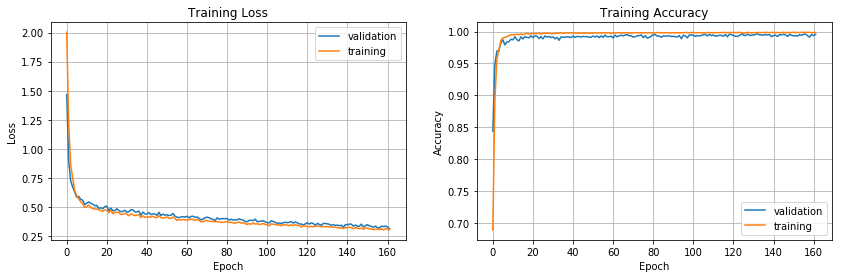

In [40]:
training_history, _ = train_model(model, params, training_dataset, validation_dataset);
display_training_history(training_history)

#### Testing

In [41]:
test_model(model, params, testing_dataset)

2017-02-22 22:04:08,402 INFO: Adding regularization to the loss operation
2017-02-22 22:04:08,621 INFO: Restoring model from 'models/architecture'
2017-02-22 22:04:09,874 INFO: Testing Accuracy = 0.985  Loss = 0.364


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [42]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
extra_file = 'data/extra.p'
with open(extra_file, mode='rb') as f:
    extra = pickle.load(f)
print("Number of extra images:", len(extra[0]))

Number of extra images: 38


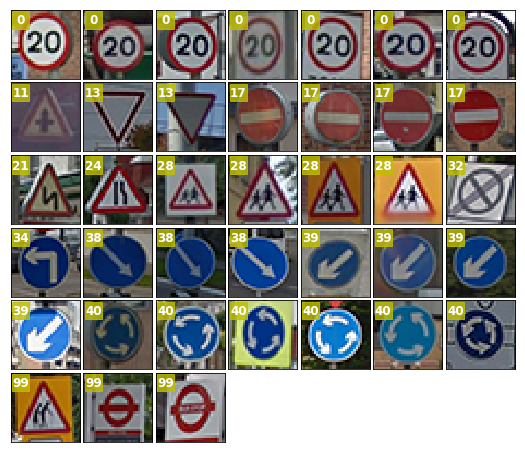

In [43]:
showgrid(extra[0], extra[1])

In [44]:
extra_dataset = (preprocess(extra[0]), extra[1])

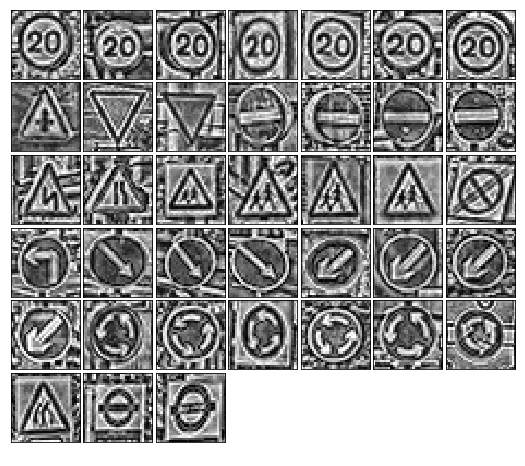

In [45]:
showgrid(extra_dataset[0], cmap='gray')

### Predict the Sign Type for Each Image

In [46]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

2017-02-22 22:04:16,098 INFO: Adding regularization to the loss operation
2017-02-22 22:04:16,282 INFO: Restored model from models/architecture


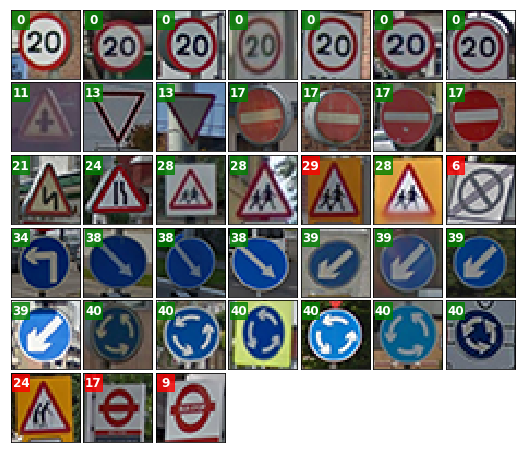

In [47]:
predictions = predict(model, params, extra_dataset[0])
matches = predictions == extra_dataset[1]
showgrid(extra[0], zip(predictions, matches))

### Analyze Performance

In [48]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [49]:
# Accuracy over the images that belong to one of the classes in the dataset
accuracy = matches.sum() / (len(predictions) - (extra[1] == 99).sum())
print("Accuracy = {:.1f}%".format(accuracy*100))

Accuracy = 94.3%


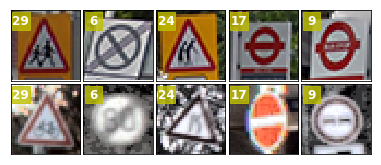

In [50]:
def random_class_sample(label):
    label_class = X_valid[y_valid == label]
    im = label_class[np.random.randint(0, len(label_class))]
    lab = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    lab[..., 0] = cv2.equalizeHist(lab[..., 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

errors = np.vstack([extra[0][~matches], list(map(random_class_sample, predictions[~matches]))])
error_labels = np.concatenate((predictions[~matches], predictions[~matches]))
showgrid(errors, error_labels, rows=2, cols=len(errors)//2)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [51]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

def predict_probabilities(model, params, X_data, top_k, restore_path=None):
    if restore_path is None:
        restore_path = 'models/' + model.__name__
    
    graph = tf.Graph()
    with graph.as_default():
        (x, y), logits, accuracy_operation, loss_operation, endpoints = build_graph(model, params)
        
    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())
        
        saver = tf.train.Saver()
        saver.restore(session, restore_path)
        logger.info("Restored model from {}".format(restore_path))
        
        # top k softmax probabilities
        probabilities_operation = tf.nn.top_k(tf.nn.softmax(logits), k=top_k)
        
        if X_data.ndim == 3:
            return session.run(prediction_operation, {x: X_data[np.newaxis]})[0]
        else:
            n_samples = len(X_data)

            probabilities = np.zeros((n_samples, top_k), dtype=np.float32)
            classes = np.zeros((n_samples, top_k), dtype=np.int8)
            
            for i in range(n_samples):
                top_kv = session.run(probabilities_operation, {x: X_data[i:i+1]})
                probabilities[i] = top_kv.values
                classes[i] = top_kv.indices
    
    return probabilities, classes

probabilities, classes = predict_probabilities(model, params, extra_dataset[0], top_k=5)

2017-02-22 22:04:20,841 INFO: Adding regularization to the loss operation
2017-02-22 22:04:21,040 INFO: Restored model from models/architecture


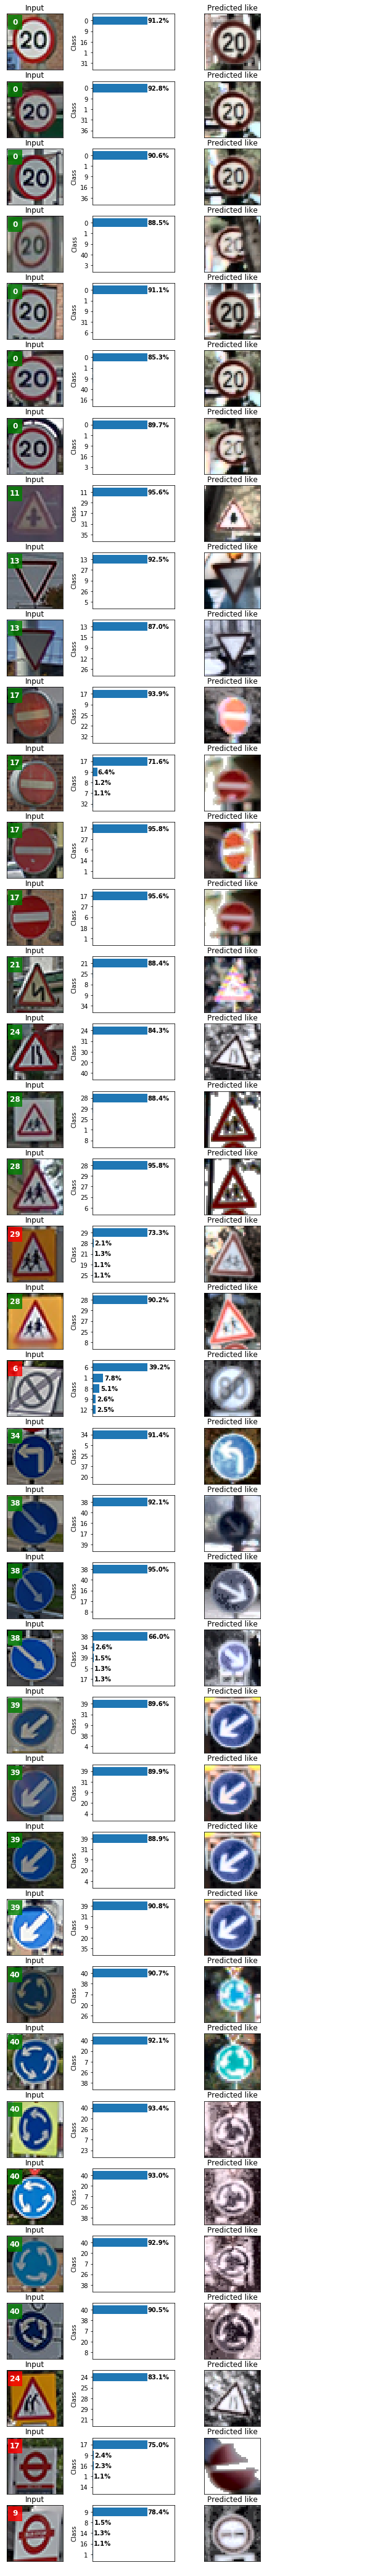

In [52]:
n_samples = len(probabilities)
fig, axes = plt.subplots(n_samples, 4, figsize=(11, 2*n_samples))
for image, p, labels, ok, ax in zip(extra[0], probabilities, classes, matches, axes):
    # reverse the order, lowest to highest to satisfy `barh`
    p = p[::-1]
    labels = labels[::-1]
    
    ax[0].imshow(image)
    ax[0].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')    
    ax[0].set_title("Input")
    
    color = 'g' if ok else 'r'
    r = matplotlib.patches.Rectangle((0.2, 0.2), 8, 8, color=color, alpha=.8)
    ax[0].add_patch(r)
    rx, ry = r.get_xy()
    cx = rx + r.get_width()/2.0
    cy = ry + r.get_height()/2.0
    ax[0].annotate(str(labels[-1]), (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')

    
    bottom = np.arange(5) + .5
    ax[1].barh(bottom, p)
    ax[1].tick_params(axis='both', bottom='off', labelbottom='off')    
    plt.sca(ax[1])
    plt.yticks(bottom, labels)    
    ax[1].margins(x=.5)
    for rect, p_ in zip(ax[1].patches, p): 
        if p_ < 0.01: continue
        ax[1].text(rect.get_x() + rect.get_width() + .01, 
                   rect.get_y() + .1, 
                   "{:.1f}%".format(p_ * 100), 
                   ha='left', va='bottom', weight='bold')
 
    ax[1].set_ylabel("Class")
    
    ax[2].imshow(random_class_sample(labels[-1]))
    ax[2].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')    
    ax[2].set_title("Predicted like")
    
    if p[-2] > .4:
        ax[3].imshow(random_class_sample(labels[-2]))
        ax[3].tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')    
        ax[3].set_title("Or ...")
    else:
        ax[3].axis('off')
        

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [53]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(session, image_input, tf_activation, activation_min=None, activation_max=None, plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    if image_input.ndim == 3:
        image_input = image_input[np.newaxis]
    image_input = preprocess(image_input)
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session, feed_dict={'x:0':image_input})

    # TensorFlow 1.0
    activation = session.run(tf_activation, {'x:0':image_input})
    featuremaps = activation.shape[3]
    rows, cols = math.ceil(featuremaps//6), 8
    
    fig = plt.figure(plt_num, figsize=(rows*2,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    im_shape = activation.shape[1], activation.shape[2]
    images = activation[0].reshape((-1,)+im_shape+(1,))    
    showgrid(images, vmin=activation_min, vmax=activation_max, interpolation='none', cmap='gray')

In [54]:
restore_path = 'models/'+model.__name__

graph = tf.Graph()
with graph.as_default():
    (x, y), logits, accuracy_operation, loss_operation, endpoints = build_graph(model, params)
    print("Endpoints:", *endpoints.keys())
    
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(session, restore_path)
    logger.info("Restored model from {}".format(restore_path))
    
    for layer in ('conv1', 'conv2'):
        tf_activation = endpoints[layer]
    
        for label in (2,20):
            label_class = y_train == label
            image = X_train[label_class][np.random.randint(0, label_class.sum()-1)]
            fig, ax = plt.subplots(1,2,figsize=(2,1))
            ax[0].imshow(image)
            ax[1].imshow(grayscale(preprocess(image), keepdims=False)[0], cmap='gray')
            ax[0].set_title("Stimulus - {} - Class {} ({})".format(layer, label, SIGNNAMES[label]), ha='left')
            ax[0].axis('off')
            ax[1].axis('off')

            outputFeatureMap(session, image, tf_activation)

2017-02-22 22:04:33,000 INFO: Adding regularization to the loss operation
2017-02-22 22:04:33,176 INFO: Restored model from models/architecture


Endpoints: conv1_1 conv1_2 conv2_1 conv2_2 conv3_1 conv3_2 logits


KeyError: 'conv1'

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 